# Стоимость жилья в РФ

## Разведочный анализ данных

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

<b>Метаинформация информация о столбах датасет.</b>

* price -  стоимость жилья
* date - дата объявления
* time - время объявления
* geo_lat - значение долготы дома
* geo_lon - значение широты дома
* region - регион
* building_type - тип зданий (0 - остальное, 1 - панель, 2 - монолит, 3 - камень, 4 - бетон, 5 - дерево)
* level - этаж
* levels - многоэтажность дома
* rooms - количество комнат
* area - площадь 
* kitchen_area - площадь кухни
* object_type - тип зданий (1 - перепродажа, 2 - новостройка)

In [67]:
data = pd.read_csv("all_v2.csv")

<b>Объединим дату и время объявлений с целью дальнейшего преобразования в timestamp и извлечения новый признаков.</b>

In [68]:
data["date_time"] = data["date"] + " " + data["time"]
data = data.drop(["date","time"],axis=1)

<b>В столбце Цена есть 356 значений с отрицательной стоимостью жилья, что в контексте данных не соотносится с логикой задачи. Поэтому удалим дубликаты и объекты недвижимости с отрицательной ценой.

Значение цены очень большое, при линейной регрессии будут искуственно завышать коэффициенты. Нужна нормализация (либо логарифмирование)</b>

In [69]:
data = data.loc[data["price"]>0]
data = data.drop_duplicates()

<b>Посмотрим первые 5 строчек датасета, чтобы понять с чем имеем дело. </b>

In [70]:
data.head()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date_time
0,6050000,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018-02-19 20:00:21
1,8650000,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018-02-27 12:04:54
2,4000000,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018-02-28 15:44:00
3,1850000,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018-03-01 11:24:52
4,5450000,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018-03-01 17:42:43


<b>Относительно мало данных о жилье. Есть несколько фичей о времени заявки, геопозиции дома, а также его общих характеристик. И только 3 признака описывающих именно недвижимость (и то все они вытекают из площади квартиры/дома). </b>

<b>Гистограмма распределения price показывает её смещение в левую сторону, а также наличие тяжелого правого хвоста. Распределение похоже на логнормальное. </b>

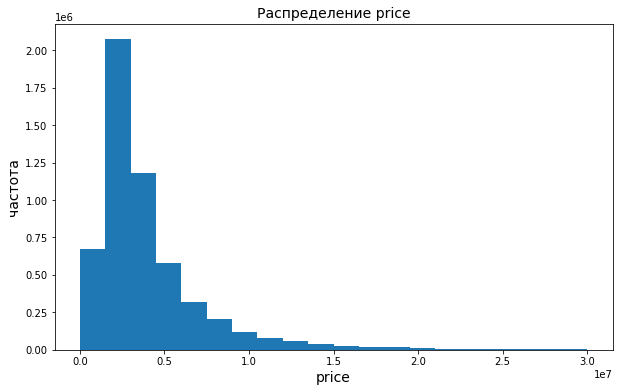

In [117]:
plt.figure(figsize=(10,6))
plt.hist(data["price"],range=(-1,30000000),bins=20)
plt.xlabel("price",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.title("Распределение price",fontsize=14);

<b> Логарифмирование приводит признак в нормально-подобный вид. </b>

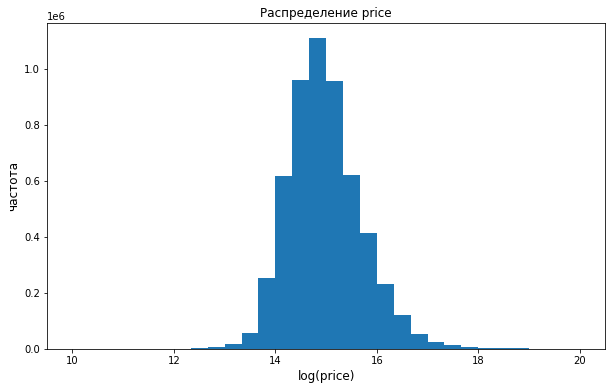

In [116]:
plt.figure(figsize=(10,6))
plt.hist(np.log(data.price),bins=30,range=(10,20))
plt.xlabel("log(price)",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.title("Распределение log(price)",fontsize=14);

<b>Q-Q график price показывает наличие невероятного количества выборосов. И логарифмирование сильно не помогает, не делает признак нормальным.  </b>

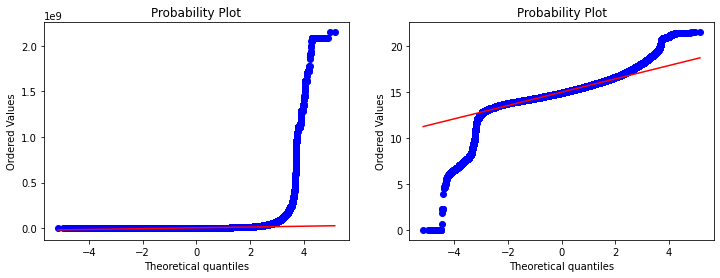

In [26]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
stats.probplot(data.price,dist="norm",plot=ax1)
ax2 = plt.subplot(122)
stats.probplot(np.log(data.price),dist="norm",plot=ax2);

<b>Теперь посмотрим на распределение признака площади в зависимости от количества комнат.</b>

In [27]:
data.groupby('rooms')[["kitchen_area","area"]].median()

,kitchen_area,area
rooms,,
-2,20.00,41.30
-1,5.00,32.47
1,10.00,37.80
2,9.50,54.00
3,10.20,72.60
4,10.80,90.00
5,16.00,147.30
6,18.00,181.00
7,20.00,212.00


<b>Есть некоторое количество записей с room = -2. Информации о том, что значит значение -2 нет. А потому стоит отфильтровать эти значения.</b>

In [71]:
data = data[data.rooms !=-2]

<b>Регионы с наибольшей разницей среднего и медианого значения цены (говорит о большим выбросах).</b>

In [29]:
data.groupby("region")["price"].agg(lambda x:np.mean(x)-np.median(x)).\
    apply(round).sort_values(ascending=False).head(5)

region
13913    10323628
3         3785349
2661      2293013
2885      1386106
9654      1163030
Name: price, dtype: int64

<b>Данные координаты соответсвуют региону Сочи. Там действительно стоимость жилья в какое-то время поднялось внезапно сильно (вероятно из-за олимпиады и чемпионатов различных). И сейчас там ведется активная застройка, а потом и в будущем можно ожидать выбросы в этом регионе.</b>

In [162]:
data.loc[data.region==13913,["geo_lat","geo_lon"]].mean()

geo_lat    43.252092
geo_lon    44.791512
dtype: float64

<b>Стоимость жилья в зависимости от тип зданий.</b>

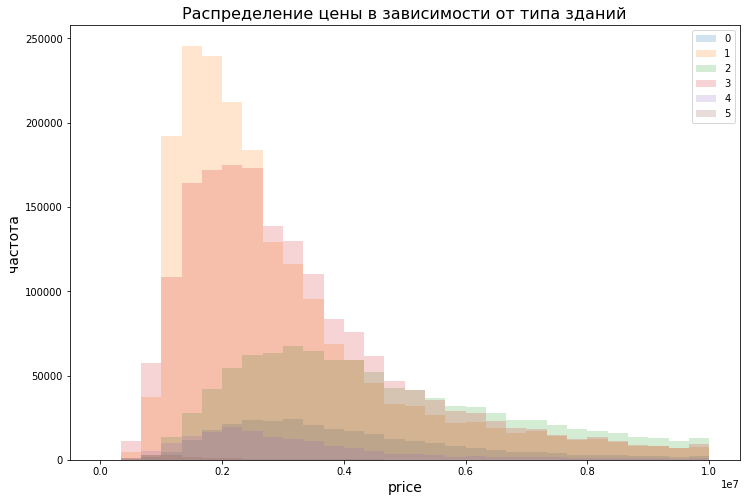

In [115]:
data.loc[data.price>500000].groupby("building_type")["price"].plot.\
    hist(range=(-1,10000000),bins=30,figsize=(12,8),alpha=0.2)
plt.title("Распределение цены в зависимости от типа зданий",fontsize=16)
plt.xlabel("price",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.legend();

<b>Стоимость недвижимости возрастает с ростом количества комнат (что очень логично).</b>

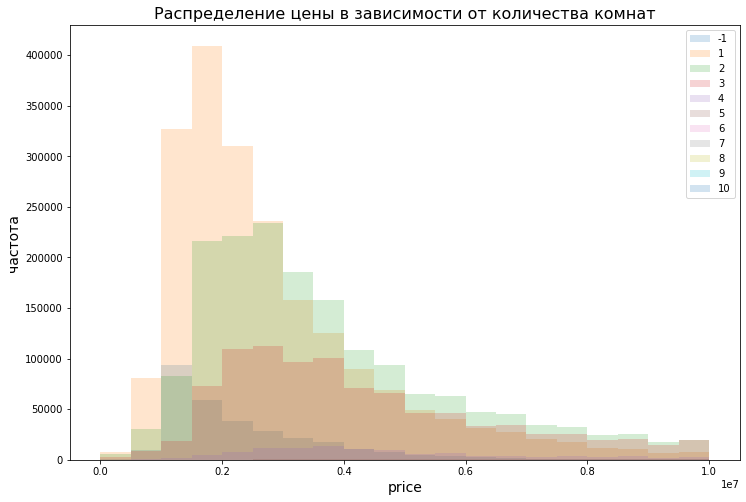

In [114]:
data.groupby("rooms")["price"].plot.hist(range=(-1,10000000),bins=20,figsize=(12,8),alpha=0.2)
plt.title("Распределение цены в зависимости от количества комнат",fontsize=16)
plt.xlabel("price",fontsize=14)
plt.ylabel("частота",fontsize=14)
plt.legend();

<b>Заметен рост стоимости из-за роста площади. Также можно заметить большое количество выбросов (дорогие регионы).</b>

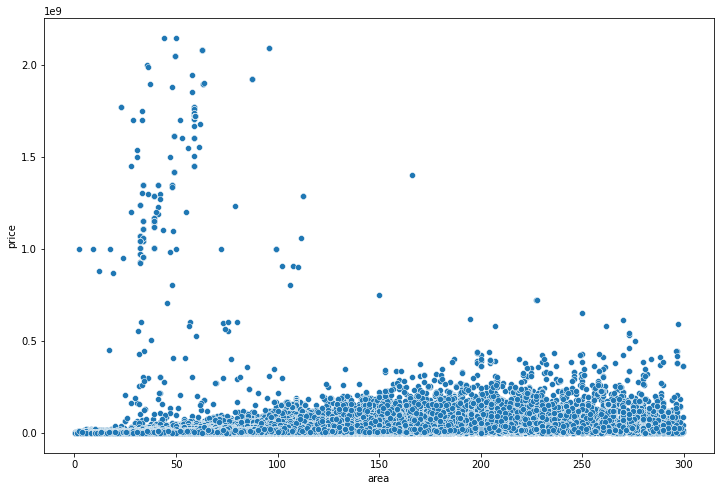

In [111]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=data.loc[data.area<300],x="area",y="price")
plot.set_xlabel("area",fontsize=16)
plot.set_ylabel("price",fontsize=16)
plot.set_title("Зависимость цены от площади",fontsize=16);

<b>Тоже самое касается и площади кухни. У которой есть некоторые фиксированные значения.</b>

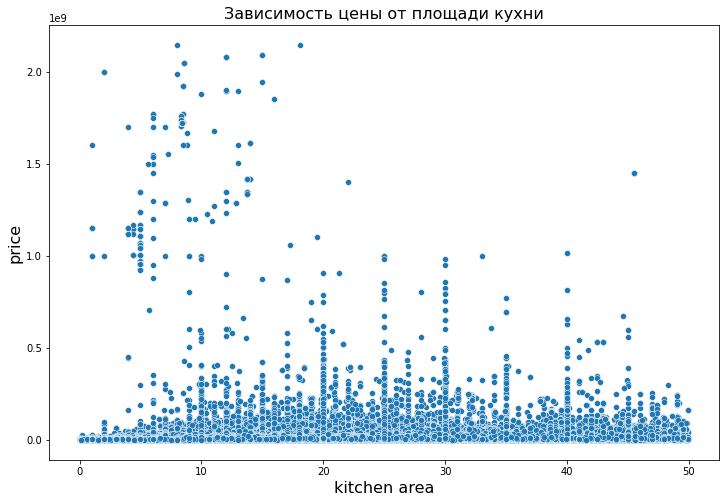

In [110]:
plt.figure(figsize=(12,8))
plot = sns.scatterplot(data=data.loc[data.kitchen_area<50],x="kitchen_area",y="price")
plot.set_xlabel("kitchen area",fontsize=16)
plot.set_ylabel("price",fontsize=16)
plot.set_title("Зависимость цены от площади кухни",fontsize=16);

<b>Теперь преобразуем date_time в timestamp и получим новые фичи (месяц и час).</b>

In [72]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [74]:
data['month'] = data['date_time'].apply(lambda x:x.month)

In [78]:
data['hour'] = data["date_time"].apply(lambda x:x.hour)

<b> Интересно с чем связано такое большое варьироваие цен в течение дня</b>

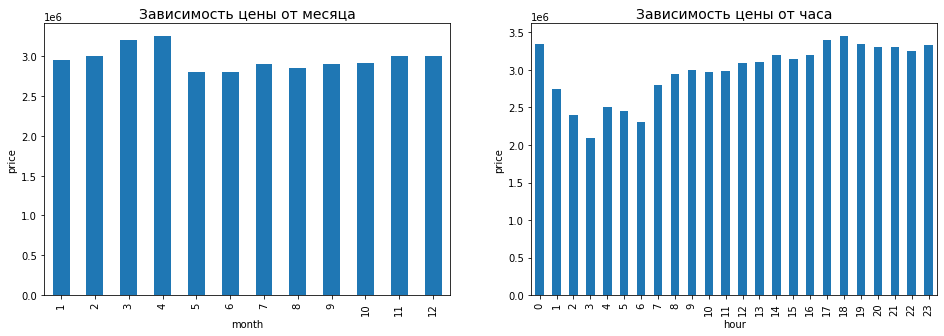

In [100]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.ylabel("price")
plt.title("Зависимость цены от месяца",fontsize=14)
data.groupby("month")["price"].median().plot.bar()
plt.subplot(122)
plt.ylabel("price")
plt.title("Зависимость цены от часа",fontsize=14)
data.groupby("hour")["price"].median().plot.bar();